In [1]:
import numpy as np
from data_loader import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure


import keras
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Dense, LSTM
from keras.models import Model, load_model
from keras.utils import plot_model, multi_gpu_model

from scipy import signal

import keras.backend as K

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


111111111111111111111111111111


In [ ]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# data_file = "/datax/yzhang/training_data/training_data_chunk_0.pkl"
# data = LoadModRecData(data_file, .9, .1, 0.)

# test_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
# testdata = LoadModRecData(test_file, 0.1, 0., 1.)


CLASSES = ['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB', 'APSK16_c34',
 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB',
 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16',
 'QAM32', 'QAM64', 'QPSK']

all_mods = [np.arange(24), np.array([1,9,10,11,12,13]), np.array([4,5]), np.array([1,9]), np.array([6,7,20,21,22])]
mods = all_mods[4]
modulations = [CLASSES[i] for i in mods]
num_classes = mods.size


data = []
for i in range(1):
    data_file = "/datax/yzhang/training_data/training_data_chunk_" + str(i) + ".pkl"
    data.append(LoadModRecData(data_file, 1., 0., 0., load_mods=modulations))
    

    
data_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(data_file, 1., 0., 0., load_mods=modulations)





[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM16
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM32
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM64
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 60000 Validation Size: 0 Test Size: 0
[Data Loader] - Done.

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding

In [3]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
number_of_samples_in_instance = data[0].instance_shape[1]
data[0].modTypes

['APSK16_c34', 'APSK32_c34', 'QAM16', 'QAM32', 'QAM64']

In [5]:
# # for each modulation type, inspect some instances of data
# for modType in data.modTypes[:]:
#     min_SNR = -10
#     max_SNR = 10
#     snr_step = 4

#     # get random snr within valid range
#     snrValue = random.randrange(min_SNR, max_SNR, snr_step)

#     # get a collection of signals
#     collection_of_instances = data.dataCube[modType, snrValue]

#     # get the complex samples for a specific instance within the collection
#     cdata, index = get_complex_samples_for_instance(collection_of_instances)
#     print(cdata.shape,index)

#     # setup inspect
#     sample_rate = number_of_samples_in_instance
#     Ts = 1.0 / sample_rate
#     t = np.arange(0, len(cdata[0])) * Ts
    
#     plt.figure()
#     plt.title(modType)
#     plt.plot(cdata.squeeze().real)
#     plt.plot(cdata.squeeze().imag)
#     # inspect signal
# plt.show()    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

In [6]:
def inception(input_img, fs=[64,64,64,64,64],height = 2, widths = [9,4],  with_residual=False):
    tower_1 = Conv2D(filters=fs[0], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size=[height, widths[0]], padding='same',activation='relu')(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size=[height, widths[1]], padding='same',activation='relu')(tower_3)
    tower_4 = MaxPooling2D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same',activation='relu')(tower_4)
    
    if len(widths) == 3:
        tower_5 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
        tower_5 = Conv2D(filters=fs[3], kernel_size=[height, widths[2]], padding='same',activation='relu')(tower_5)
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4, tower_5], axis = 3)
    else:
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_last', num_layers = [0,1,0,1], num_classes=24):
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 64, kernel_size=[2,7], strides=[2,2], data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 192, kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu')(x)
#     x = MaxPooling2D([1,3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, widths=[9,4,12], fs=[64,64,64,64,64], with_residual=True)
        x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
#         x = inception(x, widths=[9,4], fs=[48,96,48,96,96], with_residual=True)
        x = inception(x, widths=[9,4], fs=[32,32,32,32,32], with_residual=True)

#     x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x,height = 1, fs=[64,32,32,32,32])
#     x = GlobalAveragePooling1D()(x)
#     x = Conv2D(filters=64, kernel_size=[1,1], padding='same', activation='relu')(x) # optional dim reduction

    x = Dropout(0.4)(x)
    x = Flatten()(x)
#     x = Dense(64, activation='relu')(x)
#     x = Reshape((1,64))(x)
#     x = LSTM(64, return_sequences=True)(x)

#     x = Flatten()(x)

    x = Dense(num_classes, activation='softmax')(x)
    return x
in_shp = (2, 1024)
input_img = Input(shape=in_shp)
out = googleNet(input_img,data_format='channels_last', num_classes=mods.size)
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2, 1024)      0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 1024, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 512, 64)   960         reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 1, 256, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [7]:
# in_shp = (2, 1024)
# input_img = Input(shape=in_shp)
# x = Reshape(in_shp , input_shape=in_shp)(input_img)
# # x = Conv2D(filters=32, kernel_size=(1,5), padding='same', activation='relu')(x)
# # x = MaxPooling2D(pool_size=[2,2])(x)
# x = LSTM(64, return_sequences=True, input_shape=(2,1024))(x)
# # x = LSTM(64)(x)
# x = Dense(5, activation='softmax')(x)
# model = Model(inputs=input_img, outputs=x)
# model.summary()

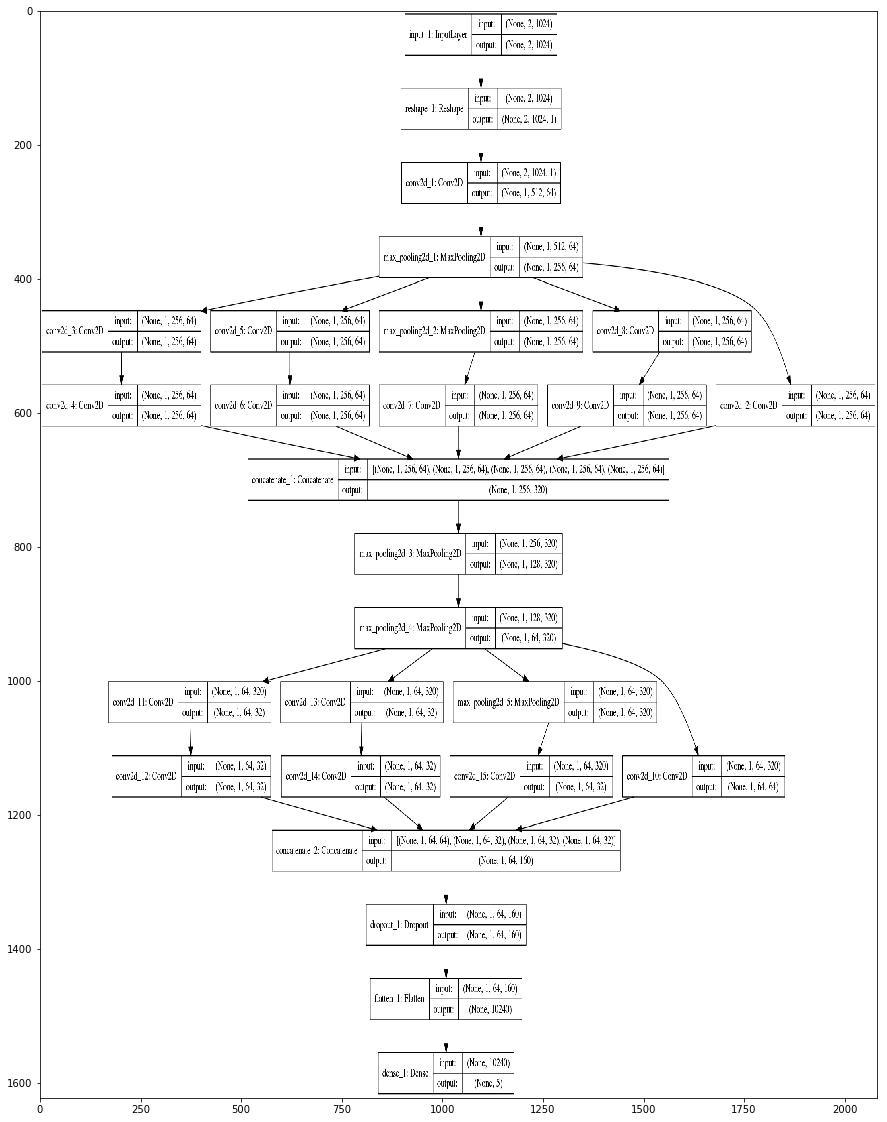

In [14]:
# Uncomment to visualize architecture
plot_model(model, to_file='model.png', show_shapes = True)

figure(figsize = (15,20))
img = mpimg.imread('model.png')
plt.imshow(img, aspect='auto')
plt.show()

In [9]:
train_batch_size, number_of_epochs = 512, 2000        

val_batches = testdata.batch_iter(testdata.train_idx, train_batch_size, number_of_epochs, use_shuffle=False)
vsteps = testdata.train_idx.size//train_batch_size


generators = []
tsteps = 0
for d in data:
    generators.append(d.batch_iter(d.train_idx, train_batch_size, number_of_epochs, use_shuffle=False))
    tsteps += d.train_idx.size

tsteps = tsteps//train_batch_size 

from utils import perturb_batch

def train_batches(noise=None):
    while True:
        batches_x, batches_y = [], []

        for gen in generators:
            batch_x, batch_y = next(gen)
            batches_x.append(batch_x)
            batches_y.append(batch_y)
            
        batches_x = np.concatenate(batches_x)
        batches_y = np.concatenate(batches_y)
        
        ##### perturb
        batches_x = perturb_batch(batches_x, batches_y)    
        #####
        
        
        if noise:
            x,y,z = batches_x.shape
            batches_x += noise * np.random.randn(x, y, z)
        idx = np.random.permutation(batches_x.shape[0])
        
        batches_x = batches_x[idx]
        batches_y = batches_y[idx]
        
        for i in range(len(generators)):
            beg = i * train_batch_size
            end = beg + train_batch_size
            yield batches_x[beg:end], batches_y[beg:end]
        

train_batches = train_batches(noise=0.25)

In [10]:
def custom_loss(y_true, y_pred):
    print(y_true.shape,y_pred.shape)
    loss = K.categorical_crossentropy(y_true, y_pred)
    print(loss)
    return 10*loss

# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [11]:
print(keras.__file__)

/home/morads/.local/lib/python3.6/site-packages/keras/__init__.py


In [13]:
# model = multi_gpu_model(model, gpus=2)
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss=custom_loss, optimizer='adam')
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

filepath = '/tmp/morads/convmodrecnets_CNN2_0.5.wts.h5'
# train_batch_size, number_of_epochs = 256, 40
# tsteps = data.train_idx.size//train_batch_size
# vsteps = data.val_idx.size//train_batch_size
# train_batches = data.batch_iter(data.train_idx, train_batch_size, number_of_epochs, use_shuffle=True)
# val_batches = data.batch_iter(data.val_idx, train_batch_size, number_of_epochs, use_shuffle=False)
# model.load_weights(filepath)
history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
     callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss'    , verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5    , verbose=0, mode='auto')
     ]) 
model.save('mod_classifier21.h5')  



print("Done")

(?, ?) (?, 5)
heeeeeeeeereeeee
Tensor("loss_1/dense_1_loss/Neg:0", shape=(?,), dtype=float32)


/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=117, verbose=2, validation_data=<generator..., validation_steps=117, callbacks=[<keras.ca..., epochs=2000)`


Epoch 1/2000
 - 12s - loss: 1.5705 - val_loss: 1.5297
Epoch 2/2000
 - 11s - loss: 1.4587 - val_loss: 1.3735
Epoch 3/2000
 - 11s - loss: 1.3628 - val_loss: 1.2951
Epoch 4/2000
 - 11s - loss: 1.3172 - val_loss: 1.2434
Epoch 5/2000
 - 11s - loss: 1.2793 - val_loss: 1.2555
Epoch 6/2000
 - 11s - loss: 1.2332 - val_loss: 1.2032
Epoch 7/2000
 - 11s - loss: 1.1884 - val_loss: 1.1319
Epoch 8/2000
 - 11s - loss: 1.1481 - val_loss: 1.0800
Epoch 9/2000
 - 11s - loss: 1.1276 - val_loss: 1.0896
Epoch 10/2000
 - 11s - loss: 1.0939 - val_loss: 0.9999
Epoch 11/2000
 - 11s - loss: 1.0849 - val_loss: 1.0463
Epoch 12/2000
 - 11s - loss: 1.0632 - val_loss: 1.0185
Epoch 13/2000
 - 11s - loss: 1.0609 - val_loss: 1.0182
Epoch 14/2000
 - 11s - loss: 1.0294 - val_loss: 1.0024
Epoch 15/2000
 - 11s - loss: 1.0189 - val_loss: 0.9792
Epoch 16/2000
 - 11s - loss: 1.0059 - val_loss: 0.9702
Epoch 17/2000
 - 11s - loss: 0.9979 - val_loss: 0.9480
Epoch 18/2000
 - 11s - loss: 0.9864 - val_loss: 0.9194
Epoch 19/2000
 - 11

In [ ]:
# model.summary()

# model2 = load_model('mod_classifier21.h5')
# model2.summary()


# model2 = load_model('mod_classifier20.h5')
# model2.summary()


Epoch 1/2000
 - 66s - loss: 0.9653 - val_loss: 0.8545
Epoch 2/2000
 - 74s - loss: 0.9408 - val_loss: 0.8492
Epoch 3/2000

In [ ]:
# Plot confusion matrix

model = load_model('../../mod_group4.h5')
acc = {}
snrs = np.arange(-15,15, 5)

classes = testdata.modTypes

print("classes ", classes)
for snr in testdata.snrValues:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(testdata.train_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
# classes  ['APSK16_c34', 'APSK32_c34', 'QAM16', 'QAM32', 'QAM64']
# SNR -10 Overall Accuracy:  0.48205 Out of 20000
# SNR -6 Overall Accuracy:  0.7817 Out of 20000
# SNR -2 Overall Accuracy:  0.9606 Out of 20000
# SNR 2 Overall Accuracy:  0.9948 Out of 20000
# SNR 6 Overall Accuracy:  0.9977 Out of 20000
# SNR 10 Overall Accuracy:  0.999 Out of 10000